# E2E solution of recommendation system

## Introduction
In this notebook, we'll demonstrate data engineering and data science work flow with an e2e sample. The scenario is to build a recommender for online book recommendation.


There are different types of recommendation algorithms, we'll use a model based collaborative filtering algorithm named Alternating Least Squares (ALS) matrix factorization in this notebook.
<img src="https://negustpublicblob.blob.core.windows.net/public/recommenders.png" style="width:600px;"/>

ALS attempts to estimate the ratings matrix R as the product of two lower-rank matrices, X and Y, i.e. X * Yt = R. Typically these approximations are called ‘factor’ matrices. 
The general approach is iterative. During each iteration, one of the factor matrices is held constant, while the other is solved for using least squares. The newly-solved factor matrix is 
then held constant while solving for the other factor matrix.

<img src="https://negustpublicblob.blob.core.windows.net/public/Matrixfactor.svg" style="width:600px;"/>


## Step 1: Load the Data

```
+--- Book-Recommendation-Dataset
|   +--- Books.csv
|   +--- Ratings.csv
|   +--- Users.csv

==> Books.csv <==
ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg

==> Ratings.csv <==
User-ID,ISBN,Book-Rating
276725,034545104X,0
276726,0155061224,5

==> Users.csv <==
User-ID,Location,Age
1,"nyc, new york, usa",
2,"stockton, california, usa",18.0
```

**By defining below parameters, we can apply this notebook on different datasets easily.**

In [3]:
IS_CUSTOM_DATA = False       # if True, dataset has to be uploaded manually

USER_ID_COL = 'User-ID'      # must not be '_user_id' for this notebook to run successfully
ITEM_ID_COL = 'ISBN'         # must not be '_item_id' for this notebook to run successfully
ITEM_INFO_COL = 'Book-Title' # must not be '_item_info' for this notebook to run successfully
RATING_COL = 'Book-Rating'   # must not be '_rating' for this notebook to run successfully
IS_SAMPLE = True             # if True, use only <SAMPLE_ROWS> rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000           # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = 'Files/book-recommendation/'  # folder containing the dataset
ITEMS_FILE = 'Books.csv'                    # file containing the items information
USERS_FILE = 'Users.csv'                    # file containing the users information
RATINGS_FILE = 'Ratings.csv'                # file containing the ratings information

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 5, Finished, Available)

### Download dataset and Upload to lakehouse

In [4]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if not exist
    remote_url = 'https://synapseaisolutionsa.blob.core.windows.net/public/Book-Recommendation-Dataset'
    file_list = ['Books.csv', 'Ratings.csv', 'Users.csv']

    # For this demo, we first check if the dataset files are already prepared in the default lakehouse. If not, we'll download the dataset.
    import os
    import requests

    if not os.path.exists('/lakehouse/default'):
        # ask user to add a lakehouse if no default lakehouse added to the notebook.
        # a new notebook will not link to any lakehouse by default.
        raise FileNotFoundError('Default lakehouse not found, please add a lakehouse for the notebook.')
    else:
        # check if the needed files are already in the lakehouse, try to download if not.
        # raise an error if downloading failed.
        os.makedirs(f'/lakehouse/default/{DATA_FOLDER}/raw/', exist_ok=True)
        for fname in file_list:
            if not os.path.exists(f'/lakehouse/default/{DATA_FOLDER}/raw/{fname}'):
                try:
                    r = requests.get(f'{remote_url}/{fname}', timeout=30)  
                    with open(f'/lakehouse/default/{DATA_FOLDER}/raw/{fname}', 'wb') as f:
                        f.write(r.content)
                    print(f'Downloaded {fname} into {DATA_FOLDER}/raw/.')
                except Exception as e:
                    print(f'Failed on downloading {fname}, error message: {e}')
            else:
                print(f'{fname} already exists in {DATA_FOLDER}/raw/.')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 6, Finished, Available)

In [5]:
# to record the notebook running time
import time

ts = time.time()

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 7, Finished, Available)

### Read data from lakehouse

In [6]:
df_items = spark.read.option('header', True) \
                     .option('inferSchema', True) \
                     .csv(f'{DATA_FOLDER}/raw/{ITEMS_FILE}')

df_ratings = spark.read.option('header', True) \
                       .option('inferSchema', True) \
                       .csv(f'{DATA_FOLDER}/raw/{RATINGS_FILE}')

df_users = spark.read.option('header', True) \
                     .option('inferSchema', True) \
                     .csv(f'{DATA_FOLDER}/raw/{USERS_FILE}')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 8, Finished, Available)

## Step 2. Exploratory Data Analysis

### Display Raw Data

We can explore the raw data with `display`, do some basic statistcs or even show chart views.

In [7]:
import pyspark.sql.functions as F

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 9, Finished, Available)

In [8]:
display(df_items, summary=True)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 10, Finished, Available)

SynapseWidget(Synapse.DataFrame, 97dc7c6d-f90e-44e5-a561-12a4d5d71811)

Add `item_id` column for later usage. `item_id` must be integer.

Using .coalesce(1) puts the Dataframe in one partition, and so have monotonically increasing and successive index column.

In [9]:
df_items = df_items.coalesce(1).withColumn("_item_id", F.monotonically_increasing_id())

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 11, Finished, Available)

In [10]:
display(df_items.sort(F.col('_item_id').desc()))

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 12, Finished, Available)

SynapseWidget(Synapse.DataFrame, 72daefa2-8be4-4d7c-90bf-0a1b299fb90c)

In [11]:
display(df_users, summary=True)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3f480390-00d4-42c8-a2e7-339be6af1095)

There is a missing value in `User-ID`, we'll drop the row with missing value.

In [12]:
df_users = df_users.dropna(subset=(USER_ID_COL))

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 14, Finished, Available)

In [13]:
display(df_users, summary=True)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, e388838f-cb84-4931-a856-074dea5336db)

Add `user_id` column for later usage. `user_id` must be integer. In this book dataset, 
we already have `User-ID` column which is integer. But we still add `user_id` column 
for compatibility to different datasets, making this notebook more robust.

In [14]:
df_users = df_users.coalesce(1).withColumn("_user_id", F.monotonically_increasing_id())

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 16, Finished, Available)

In [15]:
display(df_users.sort(F.col('_user_id').desc()))

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8250c455-7d8d-412c-84cb-8ea8b234a3cf)

In [16]:
display(df_ratings, summary=True)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2d924f62-b27a-4515-85f0-ae13fba7f00b)

In [17]:
ratings = df_ratings.select(RATING_COL).distinct().rdd.flatMap(lambda x: x).collect()
print(ratings)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 19, Finished, Available)

[1, 6, 3, 5, 9, 4, 8, 7, 10, 2, 0]


### Merge data
Merge raw dataframes into one dataframe for more comprehensive analysis.

In [18]:
from pyspark.sql import functions as F

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 20, Finished, Available)

In [19]:
df_tmp = df_ratings.join(df_users, USER_ID_COL, 'inner')
df_all = df_tmp.join(df_items, ITEM_ID_COL, 'inner')
df_all_columns = df_all.columns
df_all_columns.remove('_user_id')
df_all_columns.remove('_item_id')
df_all_columns.remove(RATING_COL)
df_all = df_all.select(['_user_id', '_item_id', RATING_COL] + df_all_columns)
df_all = df_all.withColumn('id', F.monotonically_increasing_id())

display(df_all)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 21, Finished, Available)

SynapseWidget(Synapse.DataFrame, 15a5cc32-f9ce-4cc9-b6a9-481f1c8a5d79)

In [20]:
print(f"Total Users: {df_users.select('_user_id').distinct().count()}")
print(f"Total Items: {df_items.select('_item_id').distinct().count()}")
print(f"Total User-Item Interactions: {df_all.count()}")

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 22, Finished, Available)

Total Users: 278858
Total Items: 271360
Total User-Item Interactions: 1031136


### Compute and Plot most popular items

In [21]:
# import libs

import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings


StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 23, Finished, Available)

In [22]:
# compute top popular products
df_top_items = df_all.groupby(['_item_id']).count().join(df_items, '_item_id', 'inner').sort(['count'], ascending=[0])

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 24, Finished, Available)

In [23]:
# find top <topn> popular items
topn = 10 
pd_top_items = df_top_items.limit(topn).toPandas()
pd_top_items.head()

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 25, Finished, Available)

,_item_id,count,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,26,2502,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,408,1295,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,748,883,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,1105,732,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,522,723,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


Top `<topn>` popular items, which can be used for **recommendation section "Popular"** or **"Top purchased"**.

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 26, Finished, Available)

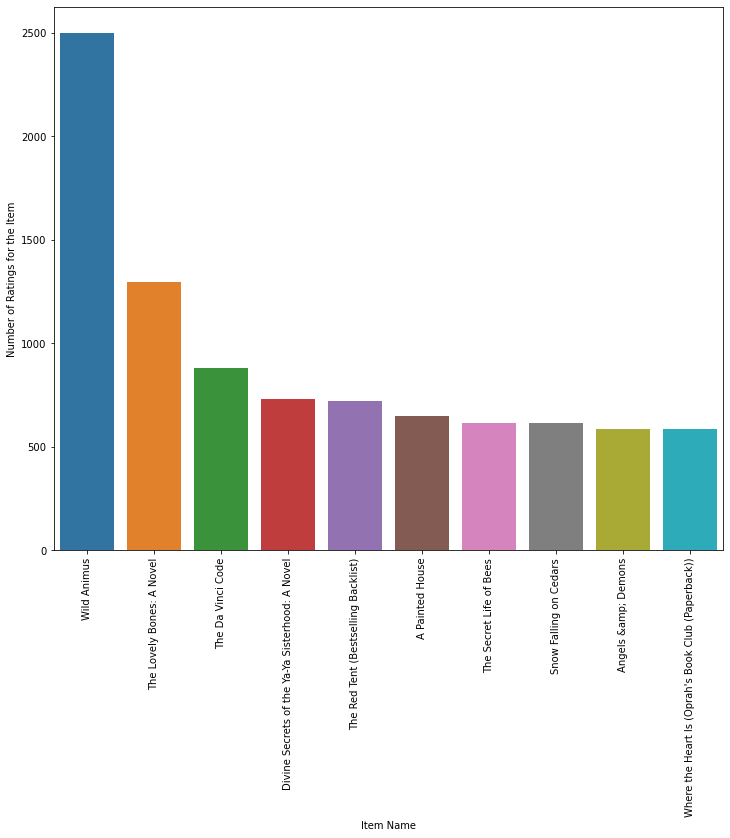

In [24]:
# Plot top <topn> items
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=ITEM_INFO_COL, y='count', data=pd_top_items)
plt.ylabel('Number of Ratings for the Item')
plt.xlabel('Item Name')
plt.show()

## Step 3. Model development and deploy
We have explored the dataset, got some insights from the exploratory data analysis and even achieved most popular recommendation.

Next, we'll develop the ALS model as mentioned in the Introduction section for more personalized recommendation.

### Prepare training and testing data

In [25]:
if IS_SAMPLE:
    # need to sort by '_user_id' before limit, so as to make sure ALS work normally.
    # if train and test dataset have no common _user_id, ALS will fail
    _df_all = df_all.sort('_user_id').limit(SAMPLE_ROWS)

fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8
    fractions_test[i] = 1
train = _df_all.sampleBy(RATING_COL, fractions=fractions_train)
test = (_df_all.join(train, on='id', how='leftanti')  # not in
              .sampleBy(RATING_COL, fractions=fractions_test))

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 27, Finished, Available)

In [26]:
# cast column into the correct types
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

train = train.withColumn("_item_id", col("_item_id").cast(IntegerType())) \
             .withColumn("_user_id", col("_user_id").cast(IntegerType())) \
             .withColumn(RATING_COL, col(RATING_COL).cast(IntegerType())) 
             
test = test.withColumn("_item_id", col("_item_id").cast(IntegerType())) \
           .withColumn("_user_id", col("_user_id").cast(IntegerType())) \
           .withColumn(RATING_COL, col(RATING_COL).cast(IntegerType())) 

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 28, Finished, Available)

In [27]:
# compute the sparsity of the dataset
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select(RATING_COL).count()
    print(f"Number of rows: {count_nonzero}")

    # Count the number of distinct user_id and distinct product_id
    total_elements = ratings.select("_user_id").distinct().count() * ratings.select("_item_id").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.4f" % sparsity + "% sparse.")
    
get_mat_sparsity(_df_all)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 29, Finished, Available)

Number of rows: 5000
The ratings dataframe is  99.8419% sparse.


In [28]:
# check the id range
# ALS only supports values in Integer range
print(f'max user_id: {_df_all.select("_user_id").rdd.max()[0]}')
print(f'max item_id: {_df_all.select("_item_id").rdd.max()[0]}')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 30, Finished, Available)

max user_id: 2275
max item_id: 246835


### Define the Model

With our data in place, we can now define the recommendation model. We'll apply Alternating Least Squares (ALS) 
model in this notebook. 

Spark ML provides a convenient API in building the model. However, the model is not good enough at 
handling problems like data sparsity and cold start. We'll combine cross validation and auto hyperparameter tuning 
to improve the performance of the model.

In [29]:
# Specify training parameters
num_epochs = 1
rank_size_list = [64, 128]
reg_param_list = [0.01, 0.1]
model_tuning_method = 'TrainValidationSplit'  # TrainValidationSplit or CrossValidator

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 31, Finished, Available)

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=num_epochs,
          userCol='_user_id', 
          itemCol='_item_id', 
          ratingCol=RATING_COL, 
          coldStartStrategy='drop', 
          implicitPrefs=False,
          nonnegative=True)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 32, Finished, Available)

### Model training and hyper-tunning

In [31]:
# Define tuning parameters
param_grid = ParamGridBuilder() \
             .addGrid(als.rank, rank_size_list) \
             .addGrid(als.regParam, reg_param_list) \
             .build()
             
print("Number of models to be tested: ", len(param_grid))

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 33, Finished, Available)

Number of models to be tested:  4


In [32]:
# Define evaluator, set rmse as loss
evaluator = RegressionEvaluator(
            metricName='rmse',
            labelCol=RATING_COL,
            predictionCol='prediction')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 34, Finished, Available)

In [33]:
# Build cross validation using CrossValidator and TrainValidationSplit
cv = CrossValidator(estimator=als,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5)

tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 35, Finished, Available)

In [34]:
if model_tuning_method == 'CrossValidator':
    # Fit cross validator to the 'train' dataset
    # As we set numFolds to 5, it will take 5 times of time on training comparing to TrainValidationSplit
    models = cv.fit(train)
elif model_tuning_method == 'TrainValidationSplit':
    # Fit train validator
    models = tvs.fit(train)
else:
    models = None

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 36, Finished, Available)

In [35]:
import numpy as np
import pandas as pd

# Extract best model
model = models.bestModel

if model_tuning_method == 'CrossValidator':
    best_params = models.getEstimatorParamMaps()[np.argmin(models.avgMetrics)]
    pd_metrics = pd.DataFrame(data={'Metric': models.avgMetrics})
elif model_tuning_method == 'TrainValidationSplit':
    best_params = models.getEstimatorParamMaps()[np.argmin(models.validationMetrics)]
    pd_metrics = pd.DataFrame(data={'Metric': models.validationMetrics})
else:
    best_params = None
    pd_metrics = None

if best_params:
    print('** Best Model **')
    for k in best_params:
        print(f'{k.name}: {best_params[k]}')

    # collect metrics    
    tmp_list = []
    for params in models.getEstimatorParamMaps():
        tmp = ''
        for k in params:
            tmp += k.name + '=' + str(params[k]) + ' '
        tmp_list.append(tmp)

    pd_metrics['Params'] = tmp_list

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 37, Finished, Available)

** Best Model **
rank: 64
regParam: 0.01


StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 38, Finished, Available)

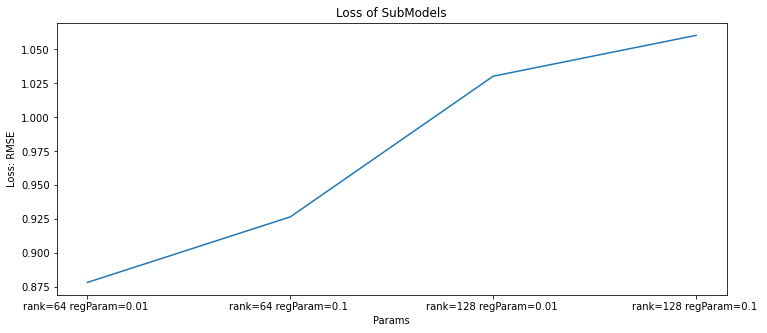

In [36]:
# Plot metrics of different submodels
f, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x=pd_metrics['Params'], y=pd_metrics['Metric'])
plt.ylabel('Loss: RMSE')
plt.xlabel('Params')
plt.title('Loss of SubModels')
plt.show()

### Model Evaluation

We now have the best model, then we can do more evaluations on the test data. 
If we trained the model well, it should have high metrics on both train and test datasets.
If we see only good metrics on train, then the model is overfitted, we may need to increase training data size.
If we see bad metrics on both datasets, then the model is not defined well, 
we may need to change model architecture or at least fine tune hyper parameters.

Evaluation on trainig data

In [37]:
# get the prediction
predictions = model.transform(train)
predictions = predictions.withColumn('prediction', predictions.prediction.cast('double'))
predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(10).show() 

# initialize the binary evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)
print(f'RMSE score = {evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})}')
print(f'MAE score = {evaluator.evaluate(predictions, {evaluator.metricName: "mae"})}')
print(f'R2 score = {evaluator.evaluate(predictions, {evaluator.metricName: "r2"})}')
print(f'Explained variance = {evaluator.evaluate(predictions, {evaluator.metricName: "var"})}')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 39, Finished, Available)

+--------+--------+-----------+------------------+
|_user_id|_item_id|Book-Rating|        prediction|
+--------+--------+-----------+------------------+
|       7|       1|          5| 4.999152660369873|
|       7|       9|          5| 4.999152660369873|
|       7|      12|          5| 4.999152660369873|
|       7|      13|          5| 4.999152660369873|
|       7|      16|          6| 5.998983860015869|
|       7|      17|          7| 6.998815059661865|
|      11|      22|         10| 9.999418258666992|
|      13|      23|          5|4.9988298416137695|
|      13|      24|          5|4.9988298416137695|
|      13|      25|          6|  5.99859619140625|
+--------+--------+-----------+------------------+

RMSE score = 0.0051972680796315935
MAE score = 0.001174051683997073
R2 score = 0.9587753377216862
Explained variance = 3.3946030804548477


Evaluation on test data.

If R2 is negative, it means the trained model is actually worse than a horizontal straight line.

In [38]:
# get the prediction
predictions = model.transform(test)
predictions = predictions.withColumn('prediction', predictions.prediction.cast('double'))
predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(10).show() 

# initialize the binary evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)
print(f'RMSE score = {evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})}')
print(f'MAE score = {evaluator.evaluate(predictions, {evaluator.metricName: "mae"})}')
print(f'R2 score = {evaluator.evaluate(predictions, {evaluator.metricName: "r2"})}')
print(f'Explained variance = {evaluator.evaluate(predictions, {evaluator.metricName: "var"})}')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 40, Finished, Available)

+--------+--------+-----------+------------------+
|_user_id|_item_id|Book-Rating|        prediction|
+--------+--------+-----------+------------------+
|     113|     114|          9| 3.386070966720581|
|     164|     134|          9| 4.142208099365234|
|     253|    5432|          9|2.1394827365875244|
|     253|    2785|          9|1.9947235584259033|
|     386|     397|          2|3.0281693935394287|
|     423|     485|          6| 4.925602912902832|
|     502|     647|         10| 3.731684446334839|
|     506|     356|         10|3.4945356845855713|
|     506|     145|          7|1.8394036293029785|
|     637|      90|         10|3.3648531436920166|
+--------+--------+-----------+------------------+

RMSE score = 5.688420428220884
MAE score = 3.048099836050454
R2 score = -5.2292729539103675
Explained variance = 27.560684272998266


### Save Model
Now we get a pretty good model, we can save it for later use.

In [39]:
import time
saved_model_path = f'{DATA_FOLDER}/als_model/{int(time.time())}'
model.save(saved_model_path)
print(f'model is saved in: {saved_model_path}')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 41, Finished, Available)

model is saved in: Files/book-recommendation//als_model/1660024471


## Step 4. Save Prediction Results

### Model Deploy and Prediction

Load Model back

In [40]:
# from pyspark.ml.recommendation import ALS
# saved_model_path = '{DATA_FOLDER}/als_model/'
# model1 = ALS.load(saved_model_path)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 42, Finished, Available)

#### Offline Recommendation
Recommend 10 items for each user

##### Save offline recommendation results

In [41]:
# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 43, Finished, Available)

In [42]:
# convert recommendations into interpretable format
userRecs = userRecs \
    .withColumn("rec_exp", F.explode("recommendations"))\
    .select('_user_id', F.col("rec_exp._item_id"), F.col("rec_exp.rating")) \
    .join(df_items.select(['_item_id', 'Book-Title']), on='_item_id')
userRecs.limit(10).show()

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 44, Finished, Available)

+--------+--------+---------+--------------------+
|_item_id|_user_id|   rating|          Book-Title|
+--------+--------+---------+--------------------+
|      17|       7| 6.998815|Goodbye to the Bu...|
|     162|       7| 6.921654|The Hitchhiker's ...|
|     914|       7|6.9048777|The Hitchhiker's ...|
|    1107|       7| 6.872694|   JITTERBUG PERFUME|
|     904|       7| 6.548902|So You Want to Be...|
|     748|       7|6.2430863|   The Da Vinci Code|
|     833|       7|6.2408624|Me Talk Pretty On...|
|     408|       7|6.2350025|The Lovely Bones:...|
|     231|       7|6.0489297|Girl with a Pearl...|
|    1777|       7|6.0303035|        The Alienist|
+--------+--------+---------+--------------------+



In [43]:
# code for saving userRecs into lakehouse
userRecs.write.mode('overwrite').parquet(f"{DATA_FOLDER}/predictions/userRecs")

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 45, Finished, Available)

In [44]:
print(f'Full run cost {int(time.time() - ts)} seconds.')

StatementMeta(, 4c706a11-e7cd-47d0-9419-6e506cf48447, 46, Finished, Available)

Full run cost 439 seconds.
